# TP2 - VP1
### Andrés Merli

Implementar la función create_gauss_filter(h, w, k_size, sigma) para crear filtros gaussianos para
filtrado espectral. Debe retornar un filtro gaussiano de tamaño HxW en dominio espacial y su transformada
de Fourier.

1. Graficar ambas representaciones para diferentes tamaños de kernel y sigma. Aplicar el filtro una
imagen para validar el funcionamiento en el dominio espectral.
2. Usando el método descripto en el paper “Image Sharpness Measure for Blurred Images in Frequency
Domain” comparar el resultado de un filtrado por convolución con el filtrado espectral.
3. Repetir la comparación usando uno de los métodos descriptos en el apéndice del paper “Analysis of
focus measure operators in shape-from-focus”


In [1]:
#%matplotlib inline  

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

### Levantamos la imagen que utlizaremos para validar el funcionamiento

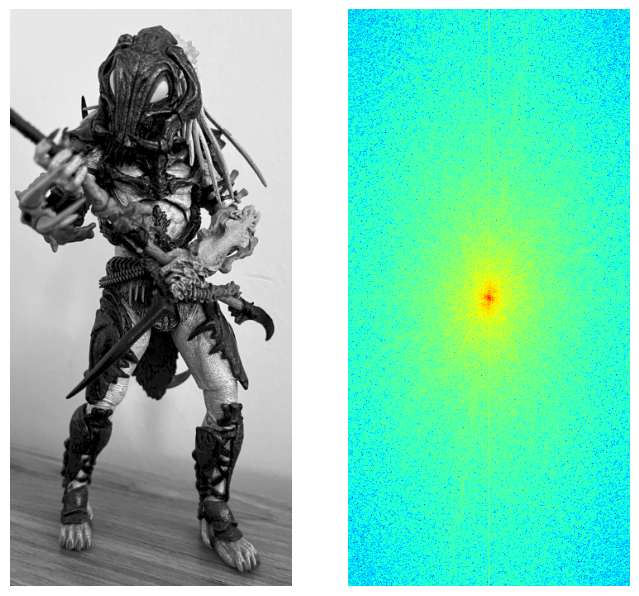

In [2]:
# Levantamos la imagen en escala de grises
img = cv.imread('fft_alfa_pred.png', cv.IMREAD_GRAYSCALE)

# Aplicamos la transformada de Fourier
img_tf = np.fft.fft2(img)

# Visualizamos la ambas imagenes
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(img, cmap='gray')
plt.subplot(1,2,2)
plt.axis('off')
#Aplicamos logaritmo y valores absolutos solo a efectos de visualizacion de la imagen transformada
plt.imshow(20*np.log(np.abs(np.fft.fftshift(img_tf))), cmap='jet')

In [3]:
img.shape

(698, 341)

### Creamos la función que retorna un filtro gaussiano de tamaño HxW y su transformada de Fourier

In [4]:
def create_gauss_filter(h, w, k_size=15, sigma=5):
    space_kernel = np.zeros((h, w))
    kernel_g = cv.getGaussianKernel(ksize=k_size, sigma=sigma)
    kernel_matrix = kernel_g * kernel_g.T
    y_center = (h // 2) - round(k_size / 2)
    x_center = (w // 2) - round(k_size / 2)
    space_kernel[y_center:y_center+k_size, x_center:x_center+k_size] = kernel_matrix
    kernel_tf = np.fft.fft2(space_kernel)
    return space_kernel, kernel_tf
    

#### Creamos filtros para el tamaño de la imagen para testing (698,341) 

#### Probamos k_size = 15, sigma = 3

In [5]:
kernel_1, kernel_tf_1 = create_gauss_filter(698, 341, k_size=15, sigma=3)

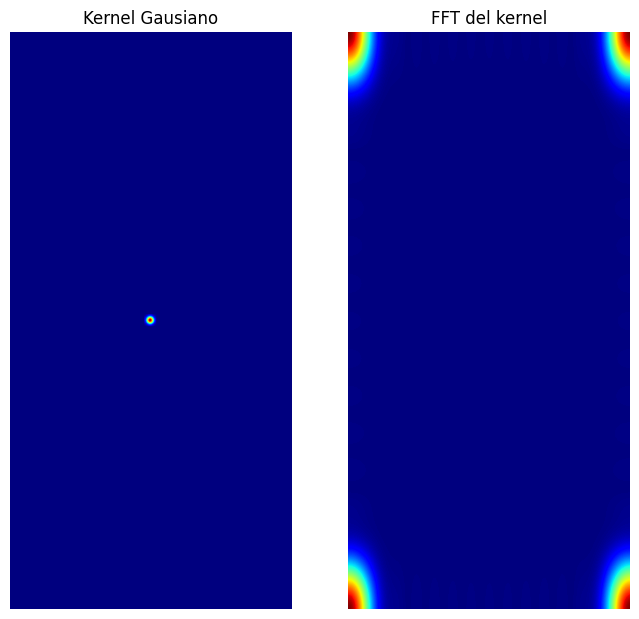

In [6]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.axis('off')
plt.title("Kernel Gausiano")
plt.imshow(kernel_1, cmap='jet')
plt.subplot(1,2,2)
plt.axis('off')
plt.title("FFT del kernel")
plt.imshow(np.abs(kernel_tf_1), cmap='jet')

Graficamos el kernel transformado de manera que quede centrado

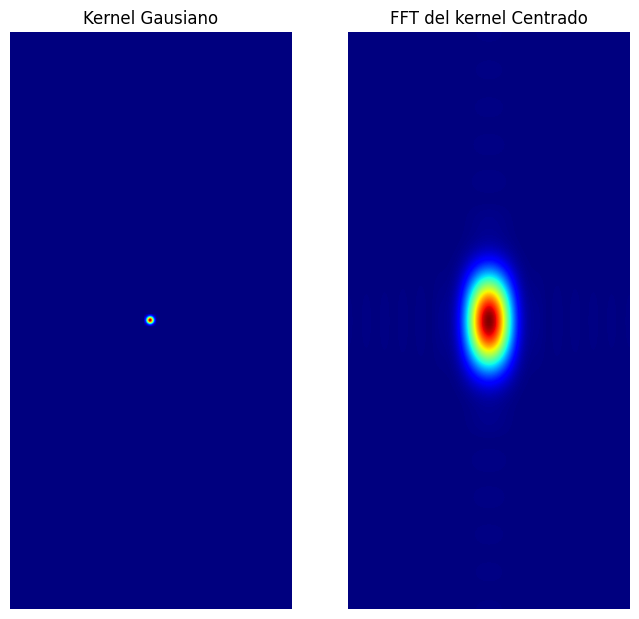

In [7]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.axis('off')
plt.title("Kernel Gausiano")
plt.imshow(kernel_1, cmap='jet')
plt.subplot(1,2,2)
plt.axis('off')
plt.title("FFT del kernel Centrado")
plt.imshow(np.abs(np.fft.fftshift(kernel_tf_1)), cmap='jet')

#### Probamos k_size = 25, sigma = 5

In [8]:
kernel_2, kernel_tf_2 = create_gauss_filter(698, 341, k_size=25, sigma=5)

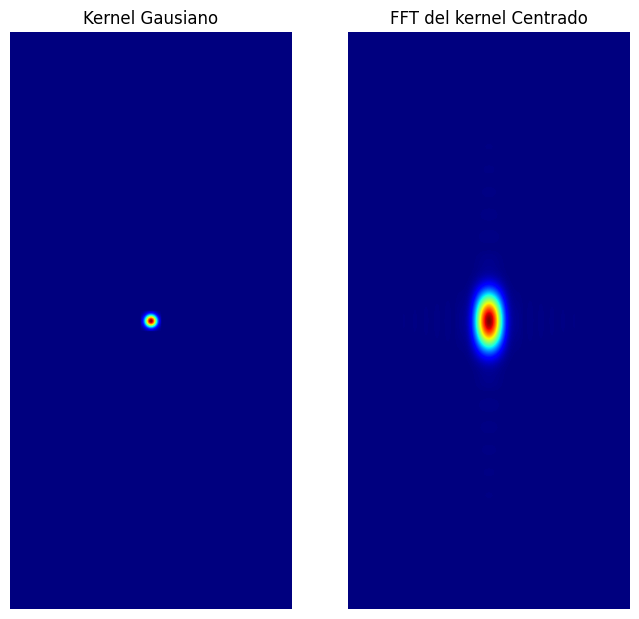

In [9]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.axis('off')
plt.title("Kernel Gausiano")
plt.imshow(kernel_2, cmap='jet')
plt.subplot(1,2,2)
plt.axis('off')
plt.title("FFT del kernel Centrado")
plt.imshow(np.abs(np.fft.fftshift(kernel_tf_2)), cmap='jet')

### Comprobamos el funcionamiento con la imagen de testing

#### Aplicamos el filtro k_size = 15, sigma=3

In [10]:
img_filtered_1 = img_tf * kernel_tf_1

Text(0.5, 1.0, 'Desenfoque gausiano k_size=15, sigma=3')

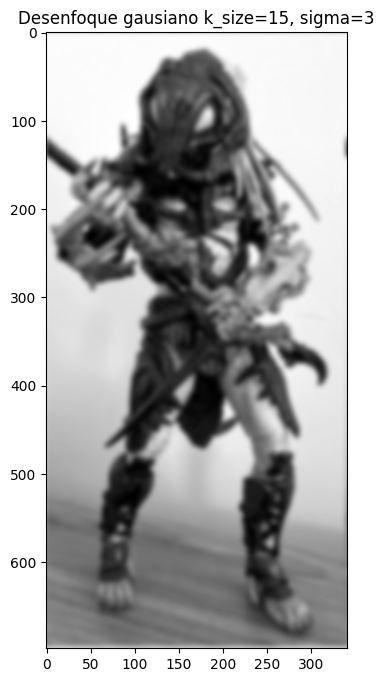

In [11]:
img_gauss_1 = np.fft.ifftshift(np.real(np.fft.ifft2(img_filtered_1)))
plt.figure(figsize=(8,8))
plt.imshow(img_gauss_1, cmap='gray')
plt.title('Desenfoque gausiano k_size=15, sigma=3')

#### Aplicamos el filtro k_size = 25, sigma=5

In [12]:
img_filtered_2 = img_tf * kernel_tf_2

Text(0.5, 1.0, 'Desenfoque gausiano k_size=25, sigma=5')

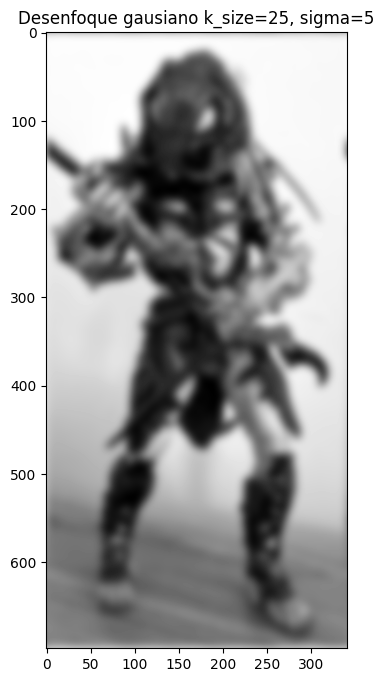

In [13]:
img_gauss_2 = np.fft.ifftshift(np.real(np.fft.ifft2(img_filtered_2)))
plt.figure(figsize=(8,8))
plt.imshow(img_gauss_2, cmap='gray')
plt.title('Desenfoque gausiano k_size=25, sigma=5')

## Creamos una funcion para calcular el indicador Image Quality

In [18]:
def calculoIndicadorBlur(input_image):
    img_F = np.fft.fft2(input_image)
    img_Fc = np.fft.fftshift(img_F)
    img_AF = np.abs(img_Fc)
    max_M = np.max(img_AF)
    thres = max_M / 1000
    count_Th = (img_F > thres).sum()
    quality_FM = count_Th / ( input_image.shape[0] * input_image.shape[1])
    return quality_FM



## Aplicamos el mismo filtrado gaussiano por convolucion de Opencv (primer filtro k_size=15, sigma=3)

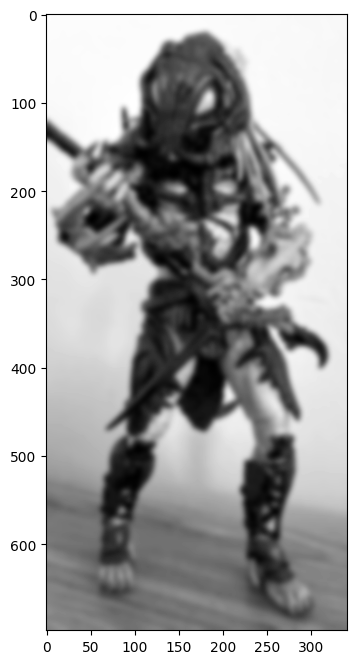

In [23]:
img_gauss_conv = cv.GaussianBlur(img, ksize=(15, 15), sigmaX=3)
plt.figure(figsize=(8,8))
plt.imshow(img_gauss_conv, cmap='gray')

### Calculamos el indicador de calidad de imagen para comparar el filtrado espectral con el de convolucion para el mismo kernel

In [19]:
calculoIndicadorBlur(img_gauss_1)

0.0037938307186851416

In [24]:
calculoIndicadorBlur(img_gauss_conv)

0.0038106361703736692

#### Obtenemos valores muy similares!

### Vamos a aplicar el algoritmo Modified Laplacian (LAP2) que se encuentra en el anexo del paper. Se menciona en el paper que en general muestra buena performance

![SNOWFALL](modified_laplacian.png)

In [49]:
def LAP2(img_input):
    mask = np.array([-1, 2, -1])
    laplacianX = np.abs(cv.filter2D(img, ddepth=-1, kernel=mask))
    laplacianY = np.abs(cv.filter2D(img, ddepth=-1, kernel=mask.T))
    return laplacianX + laplacianY

#### Vamos a visualizar que pinta tiene esto que nos devuelve el algoritmo

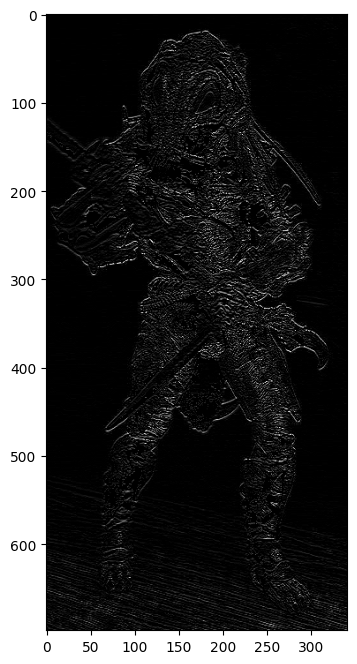

In [54]:
img_lap = LAP2(img_gauss_1)
plt.figure(figsize=(8,8))
plt.imshow(img_lap, cmap='gray')

#### Observamos que funcionaría como uns especie de detector de bordes

Vamos a medir la proporción de pixeles que están por encima de un threshold = promedio de la imagen

In [66]:
(img_lap > np.mean(img_lap)).sum() / (img_lap.shape[0] * img_lap.shape[1])

0.2109126200539455

### No me quedaba del todo claro como terminar de convertir la formula en un operador de la medida del foco de la imagen, tomé esas premisas para medir la proporción de bordes en la imagen